In [1]:
from transformers import pipeline, AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
import torch
import random
import numpy as np
from umap.umap_ import UMAP
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from datasets import ClassLabel
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score
from huggingface_hub import notebook_login
import pickle

In [105]:
wines = load_dataset("GroNLP/ik-nlp-22_winemag")

In [106]:
wines

DatasetDict({
    train: Dataset({
        features: ['index', 'country', 'description', 'points', 'price', 'province', 'variety'],
        num_rows: 70458
    })
    validation: Dataset({
        features: ['index', 'country', 'description', 'points', 'price', 'province', 'variety'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['index', 'country', 'description', 'points', 'price', 'province', 'variety'],
        num_rows: 5000
    })
})

In [107]:
print(wines["train"][42])

{'index': 59424, 'country': 'France', 'description': "A dense wine, with black fruits that go in one direction, and tannins that go in another. Maybe this is because it's young. There is some good, ripe acidity and blackberry flavors, so in six months, this may well integrate.", 'points': 85, 'price': 15.0, 'province': 'Bordeaux', 'variety': 'Bordeaux-style Red Blend'}


let's first rename the column 'variety' to 'label'. This will simply fine-tuning later on.

In [108]:
wines = wines.rename_column("variety", "label")

In [109]:
wines

DatasetDict({
    train: Dataset({
        features: ['index', 'country', 'description', 'points', 'price', 'province', 'label'],
        num_rows: 70458
    })
    validation: Dataset({
        features: ['index', 'country', 'description', 'points', 'price', 'province', 'label'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['index', 'country', 'description', 'points', 'price', 'province', 'label'],
        num_rows: 5000
    })
})

In [110]:
wines["train"].column_names

['index', 'country', 'description', 'points', 'price', 'province', 'label']

In [111]:
print(wines["train"].features)

{'index': Value(dtype='int64', id=None), 'country': Value(dtype='string', id=None), 'description': Value(dtype='string', id=None), 'points': Value(dtype='int64', id=None), 'price': Value(dtype='float64', id=None), 'province': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}


In [112]:
print(wines["train"].features["label"])

Value(dtype='string', id=None)


We'll use the columnn "variety" as the label for our classifier. However, each entry is a string and not a ClassLabel. 

In [113]:
wines = wines.class_encode_column("label")
#wines["train"] = wines["train"].class_encode_column("variety")
#wines["test"] = wines["test"].class_encode_column("variety")
#wines["validation"] = wines["validation"].class_encode_column("variety")


Casting to class labels:   0%|          | 0/70458 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/5000 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [114]:
print(wines["train"].features)

{'index': Value(dtype='int64', id=None), 'country': Value(dtype='string', id=None), 'description': Value(dtype='string', id=None), 'points': Value(dtype='int64', id=None), 'price': Value(dtype='float64', id=None), 'province': Value(dtype='string', id=None), 'label': ClassLabel(names=['Barbera', 'Bordeaux-style Red Blend', 'Bordeaux-style White Blend', 'Cabernet Franc', 'Cabernet Sauvignon', 'Champagne Blend', 'Chardonnay', 'Gewürztraminer', 'Glera', 'Grenache', 'Malbec', 'Merlot', 'Nebbiolo', 'Petite Sirah', 'Pinot Grigio', 'Pinot Gris', 'Pinot Noir', 'Portuguese Red', 'Red Blend', 'Rhône-style Red Blend', 'Riesling', 'Rosé', 'Sangiovese', 'Sangiovese Grosso', 'Sauvignon Blanc', 'Sparkling Blend', 'Syrah', 'Tempranillo', 'Tempranillo Blend', 'Viognier', 'White Blend', 'Zinfandel'], id=None)}


In [115]:
wines.set_format(type="pandas")
df = wines["train"][:]
df.head()

,index,country,description,points,price,province,label
0,129857,US,Dusty tannins make for a soft texture in this ...,90,44.0,California,11
1,112217,US,Sweet-tart Maraschino cherry and bitter brambl...,85,14.0,New York,16
2,114216,France,A lightly orange-colored rosé that is made by ...,92,90.0,Champagne,5
3,37808,France,"A ripe wine that is almost off dry, this has a...",85,17.0,Bordeaux,1
4,31157,US,"Crisp and very floral, this is a beautiful sho...",92,20.0,California,15


In [117]:
def label_int2str(row):
    return wines["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)


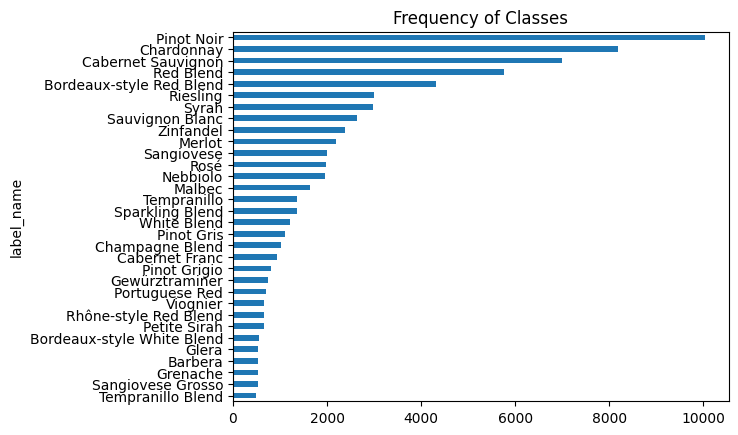

In [118]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

The classes are terribly unbalanced and significantly skewed towards Pinot Noir. While I'm impartial to a glass of Pinot, we will need to revisit this later. For now, let's cautiously proceed.

In [119]:
df["words per description"] = df["description"].str.split().apply(len)

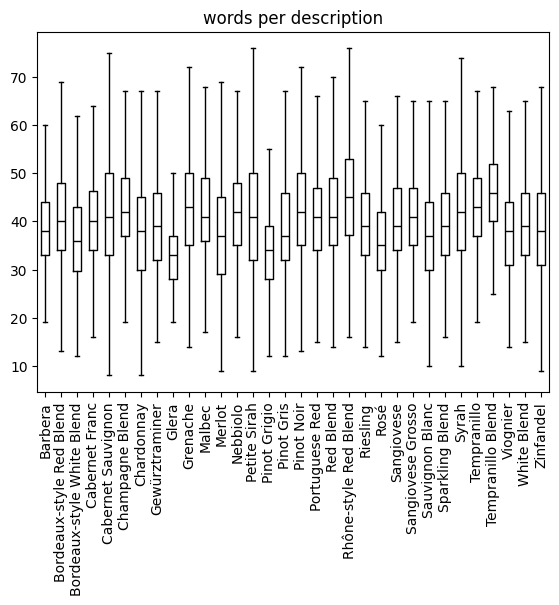

In [120]:
df.boxplot("words per description", by="label_name", grid=False,
          showfliers=False, color="black", rot=90)
plt.suptitle("")
plt.xlabel("")
plt.show()

most descriptions tend to be around 40-45 words in length with the longest reviews being 80 words.

Before we go any further, we need to reset the output format as we no longer need to work with DataFrames.

In [121]:
wines.reset_format()

In [122]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/home/djh/Development/python/wine-classification/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [123]:
encoded_text = tokenizer(wines["train"][42]["description"])
print(encoded_text)

{'input_ids': [101, 1037, 9742, 4511, 1010, 2007, 2304, 10962, 2008, 2175, 1999, 2028, 3257, 1010, 1998, 9092, 11483, 2015, 2008, 2175, 1999, 2178, 1012, 2672, 2023, 2003, 2138, 2009, 1005, 1055, 2402, 1012, 2045, 2003, 2070, 2204, 1010, 22503, 5648, 3012, 1998, 25935, 26389, 1010, 2061, 1999, 2416, 2706, 1010, 2023, 2089, 2092, 17409, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [124]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'a', 'dense', 'wine', ',', 'with', 'black', 'fruits', 'that', 'go', 'in', 'one', 'direction', ',', 'and', 'tan', '##nin', '##s', 'that', 'go', 'in', 'another', '.', 'maybe', 'this', 'is', 'because', 'it', "'", 's', 'young', '.', 'there', 'is', 'some', 'good', ',', 'ripe', 'acid', '##ity', 'and', 'blackberry', 'flavors', ',', 'so', 'in', 'six', 'months', ',', 'this', 'may', 'well', 'integrate', '.', '[SEP]']


In [125]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] a dense wine, with black fruits that go in one direction, and tannins that go in another. maybe this is because it ' s young. there is some good, ripe acidity and blackberry flavors, so in six months, this may well integrate. [SEP]


In [126]:
tokenizer.vocab_size

30522

In [127]:
tokenizer.model_max_length

512

This is a small context length but should be more than amble for this use case given the maximum review size is about 80 words.

In [128]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

This should come as no surprise as we saw this earlier.

In [129]:
def tokenize(batch):
    return tokenizer(batch["description"], padding=True, truncation=True)

In [130]:
print(tokenize(wines["train"][:3]))

{'input_ids': [[101, 12727, 9092, 11483, 2015, 2191, 2005, 1037, 3730, 14902, 1999, 2023, 4511, 2008, 1005, 1055, 11259, 1999, 9550, 5909, 1010, 4234, 17688, 1010, 7967, 1998, 18856, 21818, 1012, 2009, 18058, 14894, 1998, 11619, 2302, 7729, 1010, 1037, 7842, 14550, 2100, 3670, 1997, 1996, 14722, 2013, 1037, 4659, 4658, 4785, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 4086, 1011, 16985, 2102, 13955, 11624, 5740, 9115, 1998, 8618, 20839, 3468, 3964, 11463, 2094, 1999, 2023, 8595, 2100, 1010, 3078, 2417, 4511, 1012, 13675, 2319, 9766, 5648, 3012, 4978, 1996, 3054, 19636, 2618, 2007, 1037, 8560, 23690, 2486, 1998, 26577, 2015, 2083, 1037, 17844, 2146, 3926, 1012, 4392, 2085, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1037, 8217, 4589, 1011, 6910, 3123, 2008, 2003, 2081, 2011, 19382, 15172, 1996, 16575, 2006, 1996, 21049, 2005, 5824, 2847, 1012, 1996, 2765, 2003, 1037, 3730, 4511, 1010, 2200, 4318, 2096, 2036, 4760, 1037, 8352, 2839, 2008, 3957, 4138, 2791, 1012, 22503, 2417, 1

There are several zeros in the attention mask for the first two tokenized strings. This happens because the tokenised strings are shorter than the longest ```python wines["train"][2]``` and so they are padded with zeros.

In [131]:
wines_encoded = wines.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/70458 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [132]:
print(wines_encoded["train"].column_names)

['index', 'country', 'description', 'points', 'price', 'province', 'label', 'input_ids', 'attention_mask']


In [133]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [134]:
text = "This tastes like red wine."
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 8])


In [135]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.0846, -0.0268,  0.0995,  ..., -0.2137,  0.2830,  0.2148],
         [ 0.0539,  0.0750,  0.1434,  ..., -0.2600,  0.4398,  0.2631],
         [ 0.0135,  0.2048,  0.3355,  ..., -0.4023,  0.0500,  0.0580],
         ...,
         [ 0.5952,  0.2765,  0.1802,  ..., -0.0500,  0.1669, -0.3235],
         [ 0.8180,  0.0557, -0.4205,  ..., -0.0975, -0.3562, -0.5558],
         [ 0.3269,  0.2218,  0.2999,  ..., -0.3759,  0.4464, -0.2071]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [136]:
outputs.last_hidden_state.size()

torch.Size([1, 8, 768])

In [137]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [138]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [139]:
wines_encoded.set_format("torch",
                        columns=["input_ids", "attention_mask", "label"])

In [140]:
wines_hidden = wines_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/70458 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [141]:
wines_hidden["train"].column_names

['index',
 'country',
 'description',
 'points',
 'price',
 'province',
 'label',
 'input_ids',
 'attention_mask',
 'hidden_state']

In [142]:
X_train = np.array(wines_hidden["train"]["hidden_state"])
X_valid = np.array(wines_hidden["validation"]["hidden_state"])
y_train = np.array(wines_hidden["train"]["label"])
y_valid = np.array(wines_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((70458, 768), (5000, 768))

In [143]:
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,6.233334,-0.769254,11
1,5.138820,2.803423,16
2,4.620096,2.663336,5
3,3.815237,-2.111836,1
4,7.746033,0.984053,15


In [144]:
cmaps = random.sample(list(colormaps), k=32)
print(cmaps)

['Set1_r', 'RdYlBu', 'twilight_shifted', 'winter', 'ocean', 'gray', 'YlOrBr', 'RdGy', 'gist_rainbow_r', 'PuOr', 'prism_r', 'PuBuGn_r', 'Blues', 'turbo', 'PuRd', 'gnuplot', 'hsv', 'bwr_r', 'tab20_r', 'gnuplot2_r', 'gist_heat', 'Pastel1_r', 'PuBu_r', 'gnuplot2', 'RdPu_r', 'Accent', 'inferno', 'bone', 'Accent_r', 'magma_r', 'gray_r', 'binary']


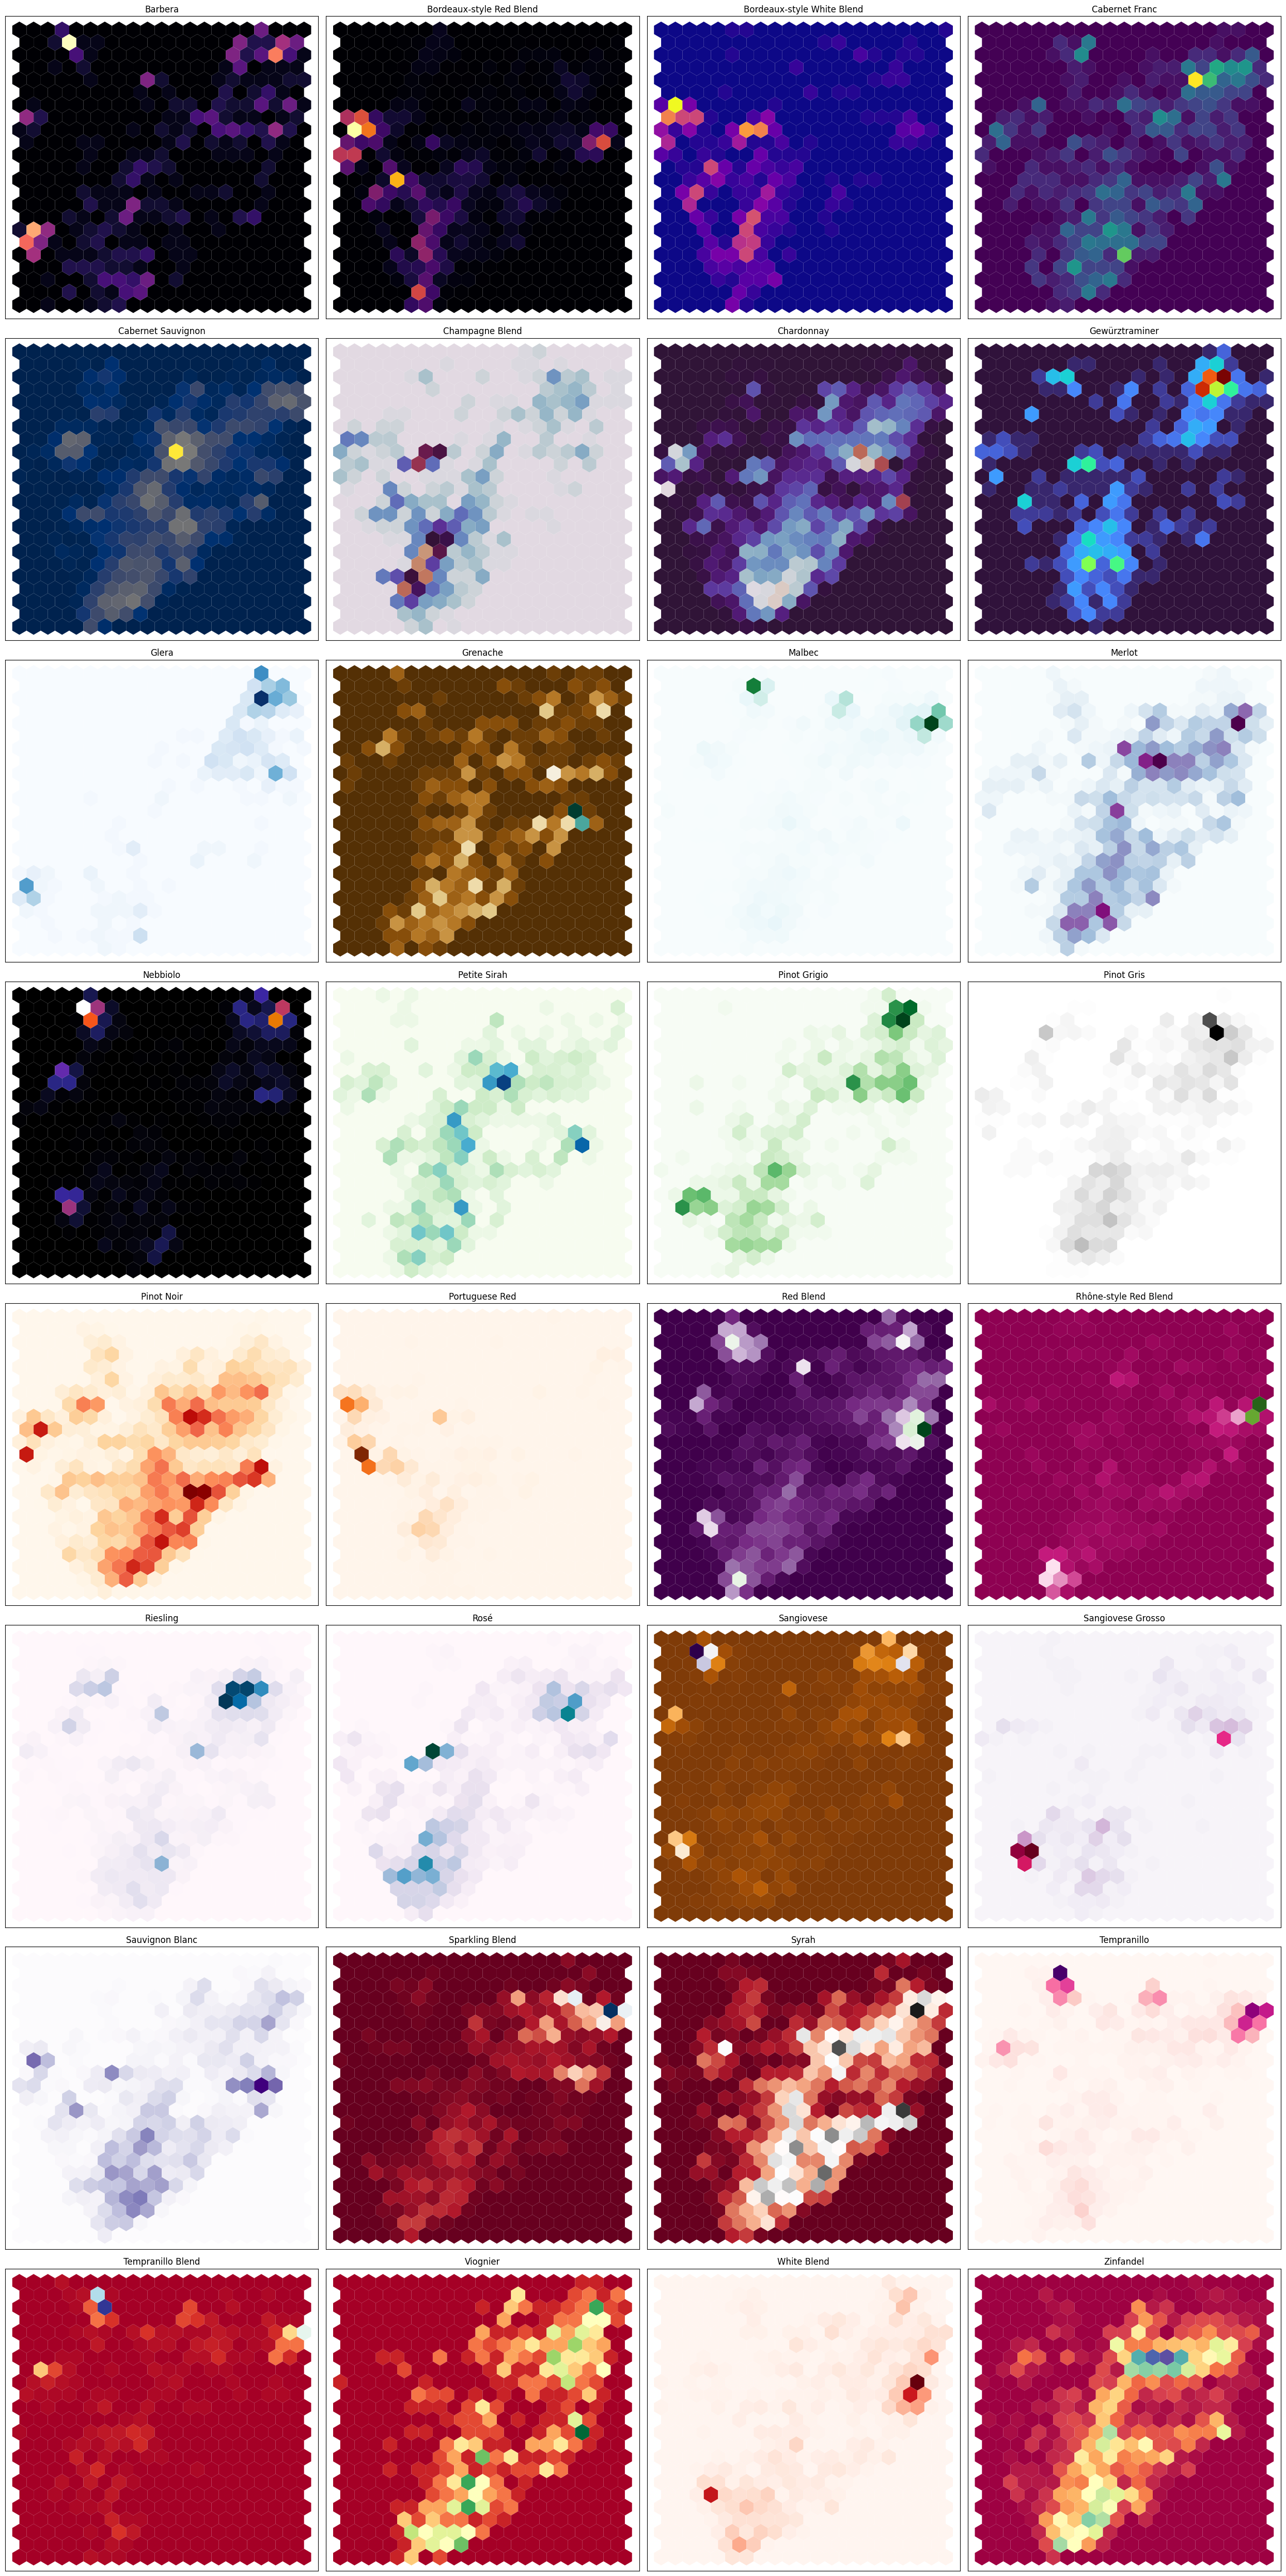

In [147]:
fig, axes = plt.subplots(8, 4, figsize=(25,50))
axes = axes.flatten()
cmaps = list(colormaps)[:32]
labels = wines["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(varieties, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [61]:
#scikit learn doesn't appear to natively support a GPU????!!!
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.5838

let's save this to disk to avoid recompyting the model in the future.

In [63]:
# with open('lr_clf_model.pkl', 'wb') as f:
#     pickle.dump(lr_clf, f)

In [40]:
with open('lr_clf_model.pkl', 'rb') as f:
    lr_clf = pickle.load(f)

In [41]:
lr_clf.score(X_valid, y_valid)

0.5838

This looks little better than random chance but as we saw earlier the distrubution is skewed. Let's see how much better than random chance it is.

In [42]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.14

This is much, much better than chance.

In [161]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(32, 32))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False, xticks_rotation='vertical')
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, varieties)

NameError: name 'lr_clf' is not defined

Let's now fine-tune our model. Instead of using the hidden state as fixed features we'll train them.

In [148]:
num_labels = 32
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

/home/djh/Development/python/wine-classification/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [149]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [96]:
notebook_login()

In [150]:
batch_size = 64
logging_steps = len(wines_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-wine"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

In [151]:
print(wines_encoded["validation"].column_names)

['index', 'country', 'description', 'points', 'price', 'province', 'label', 'input_ids', 'attention_mask']


In [152]:
print(wines_encoded["validation"][:10])

{'label': tensor([13,  8, 26, 24, 25,  4, 16, 18,  4,  6]), 'input_ids': tensor([[ 101, 2009, 2097,  ...,    0,    0,    0],
        [ 101, 2023, 7480,  ...,    0,    0,    0],
        [ 101, 7199, 2312,  ...,    0,    0,    0],
        ...,
        [ 101, 2023, 2540,  ...,    0,    0,    0],
        [ 101, 2625, 3202,  ...,    0,    0,    0],
        [ 101, 4840, 1010,  ...,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


In [153]:
print(wines_encoded["train"])

Dataset({
    features: ['index', 'country', 'description', 'points', 'price', 'province', 'label', 'input_ids', 'attention_mask'],
    num_rows: 70458
})


In [155]:
type(wines_encoded["validation"][:10]["label"])

torch.Tensor

label is represented as a torch.Tensor. Each element of the tensor corresponds to a number between 1 and 32 as there are 32 class labels. 

In [156]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=wines_encoded["train"],
                  eval_dataset=wines_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.673500,1.125852,0.679400,0.663819
2,1.064600,1.001704,0.708000,0.694276


TrainOutput(global_step=2202, training_loss=1.3686562786310181, metrics={'train_runtime': 867.4146, 'train_samples_per_second': 162.455, 'train_steps_per_second': 2.539, 'total_flos': 7076742159416832.0, 'train_loss': 1.3686562786310181, 'epoch': 2.0})

In [157]:
preds_output = trainer.predict(wines_encoded["validation"])

In [158]:
preds_output.metrics

{'test_loss': 1.0017037391662598,
 'test_accuracy': 0.708,
 'test_f1': 0.694276376831405,
 'test_runtime': 7.3915,
 'test_samples_per_second': 676.449,
 'test_steps_per_second': 10.688}

In [159]:
y_preds = np.argmax(preds_output.predictions, axis=1)

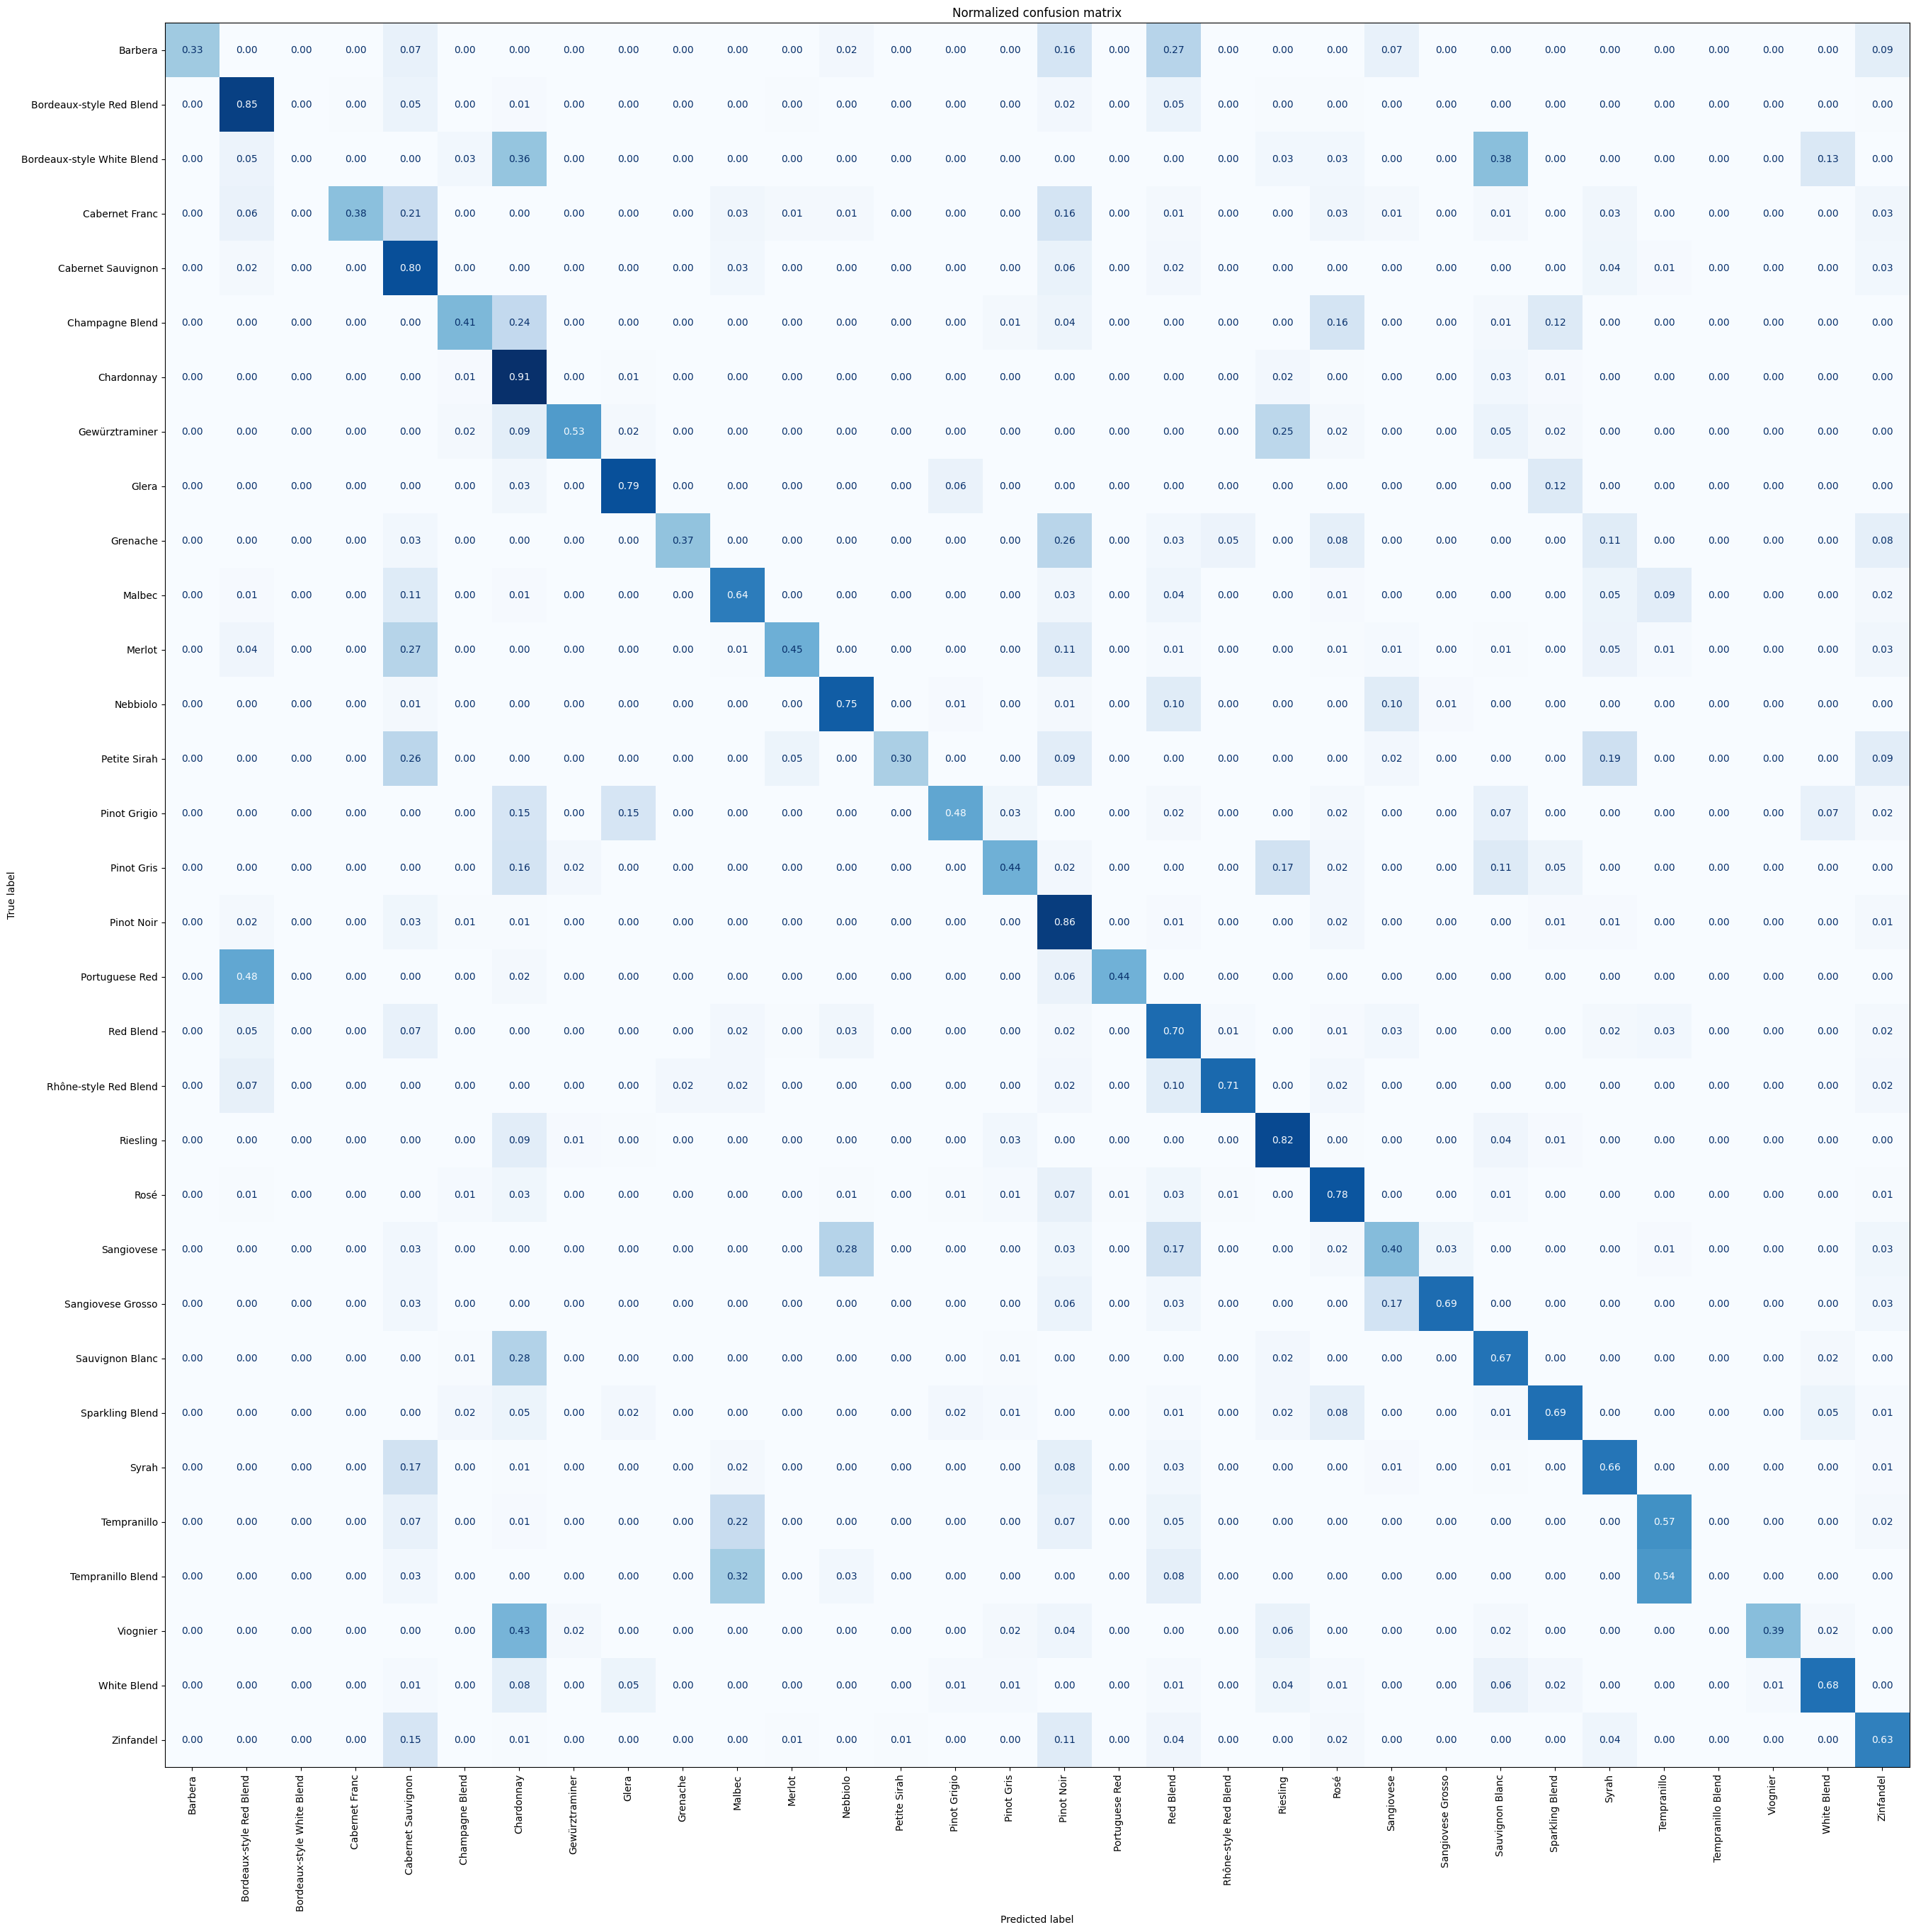

In [162]:
plot_confusion_matrix(y_preds, y_valid, labels)

In [163]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

In [164]:
#hide_output
# Convert our dataset back to PyTorch tensors
wines_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
wines_encoded["validation"] = wines_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [166]:
wines_encoded.set_format("pandas")
cols = ["description", "label", "predicted_label", "loss"]
df_test = wines_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [167]:
#hide_output
df_test.sort_values("loss", ascending=False).head(10)

,description,label,predicted_label,loss
4939,There are soft grapefruit-peach aromas and fla...,Bordeaux-style Red Blend,Riesling,7.656814
1082,"Easy and informal, this Bardolino (a blend of ...",Rosé,Red Blend,7.169814
3218,Somewhat severe with a stalky fruit character ...,Rhône-style Red Blend,Bordeaux-style Red Blend,7.116294
3530,Solid and tannic with a stalky character both ...,Rhône-style Red Blend,Bordeaux-style Red Blend,7.110259
3151,"This is a heavy, soft, jammy wine that's sweet...",Pinot Grigio,Zinfandel,7.102837
518,Whistler Vineyard is an extreme site on the co...,Viognier,Pinot Noir,6.810459
4452,Crisp and brightfresh acidity and ethereal aro...,Nebbiolo,Pinot Grigio,6.755197
1728,Put your nose to the glass and you will be rew...,White Blend,Chardonnay,6.650002
2330,This wine packs a big wallop of superripe flav...,Rhône-style Red Blend,Pinot Noir,6.527816
3526,"This starts with subtle aromas of wild rise, l...",Sparkling Blend,Red Blend,6.478491


In [168]:
#hide_output
df_test.sort_values("loss", ascending=True).head(10)

,description,label,predicted_label,loss
4274,"Breggo has produced a fine, ageable Pinot Noir...",Pinot Noir,Pinot Noir,0.011215
848,"A beautiful, young and firmly tannic Pinot Noi...",Pinot Noir,Pinot Noir,0.011227
2874,"Ripe, flashy raspberry, cherry and red currant...",Pinot Noir,Pinot Noir,0.011294
533,Tin House has been producing good Pinot Noirs ...,Pinot Noir,Pinot Noir,0.011452
2786,"When a young Pinot Noir is dominated by oak, a...",Pinot Noir,Pinot Noir,0.011494
1437,"One of Testarossa's best 2011 Pinot Noirs, of ...",Pinot Noir,Pinot Noir,0.011526
3509,This young Pinot Noir is difficult and challen...,Pinot Noir,Pinot Noir,0.011546
4315,An intriguing Pinot Noir that shows the possib...,Pinot Noir,Pinot Noir,0.011604
4711,"Shows the crisp, silky elegance and spicy frui...",Pinot Noir,Pinot Noir,0.011667
3915,Give this Pinot Noir a couple of years to kni...,Pinot Noir,Pinot Noir,0.011714


We should remove all labels from the description. No wonder it does so well!

In [169]:
trainer.push_to_hub(commit_message="First training run complete. Lots to improve upon, but it's a start.")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/danieljhand/distilbert-base-uncased-finetuned-wine/commit/cf8e6aab8bf81bf6a43af4329a34b1e487c84c4d', commit_message="First training run complete. Lots to improve upon, but it's a start.", commit_description='', oid='cf8e6aab8bf81bf6a43af4329a34b1e487c84c4d', pr_url=None, pr_revision=None, pr_num=None)

let's now use the model from huggingface.

In [170]:
model_id = "danieljhand/distilbert-base-uncased-finetuned-wine"
classifier = pipeline("text-classification", model=model_id)

/home/djh/Development/python/wine-classification/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.96k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [188]:
wine_review = "Blackcurrants, cedar, cassis, liquorice, coffee beans, green pepper"
preds = classifier(wine_review, return_all_scores=True)

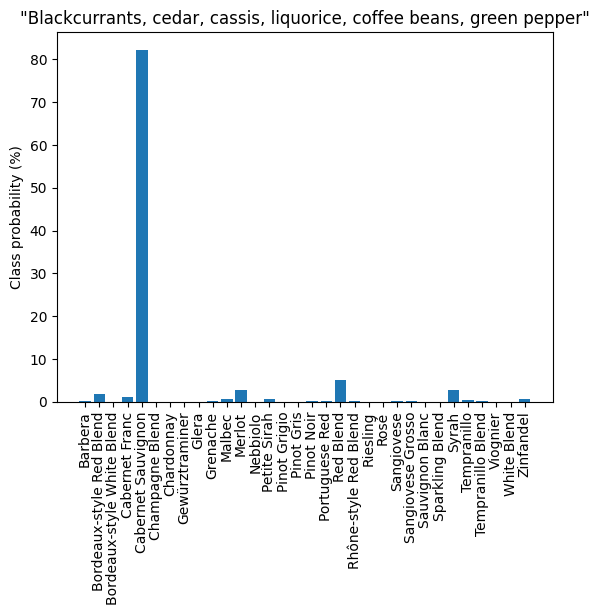

In [189]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.xticks(rotation=90)
plt.title(f'"{wine_review}"')
plt.ylabel("Class probability (%)")
plt.show()